In [1]:
import os
import dask
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from pathlib import Path

# To use dask across the cluster
from dask_jobqueue import SLURMCluster
from dask.distributed import Client

# Plots with iris
import iris
import iris.plot as iplt
import iris.quickplot as qplt

import matplotlib
matplotlib.rcParams.update({'font.size': 15})

### Set up cluster client

In [4]:
cluster = SLURMCluster()
print(cluster.job_script())
client = Client(cluster)

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p broadwl
#SBATCH -n 1
#SBATCH --cpus-per-task=4
#SBATCH --mem=19G
#SBATCH -t 00:30:00
#SBATCH --qos=covid-19
#SBATCH --account=covid-19
#SBATCH --output=dask_worker.out
#SBATCH --error=dask_worker.err

/scratch/midway2/ivanhigueram/reanalysis_env/bin/python -m distributed.cli.dask_worker tcp://172.25.220.71:36418 --nthreads 4 --memory-limit 20.00GB --name name --nanny --death-timeout 60 --local-directory $SCRATCH --interface ib0



/scratch/midway2/ivanhigueram/reanalysis_env/lib/python3.7/site-packages/distributed/node.py:244: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35499 instead
  http_address["port"], self.http_server.port


In [5]:
cluster.scale(5)

In [3]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:45826")
client

Client Scheduler: tcp://127.0.0.1:45826 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 7 Cores: 28 Memory: 60.13 GB


### Load T-prime files in parallel

In [4]:
def preprocess(ds):
    ds = ds.sortby('time')
    #means_period = ds.mean(dim='time')
    
    return ds 

In [5]:
paths = list(Path('/project2/geos39650/jet_stream/data/').rglob('t_prime_test_blobs_no_resample*'))

In [6]:
paths

[PosixPath('/project2/geos39650/jet_stream/data/model_output/tprime/t_prime_test_blobs_no_resample_1990-12-01_1995-03-01.nc4'),
 PosixPath('/project2/geos39650/jet_stream/data/model_output/tprime/t_prime_test_blobs_no_resample_1995-12-01_2000-03-01.nc4'),
 PosixPath('/project2/geos39650/jet_stream/data/model_output/tprime/t_prime_test_blobs_no_resample_2010-12-01_2015-03-01.nc4'),
 PosixPath('/project2/geos39650/jet_stream/data/model_output/tprime/t_prime_test_blobs_no_resample_1980-12-01_1985-03-01.nc4'),
 PosixPath('/project2/geos39650/jet_stream/data/model_output/tprime/t_prime_test_blobs_no_resample_2015-12-01_2020-03-01.nc4'),
 PosixPath('/project2/geos39650/jet_stream/data/model_output/tprime/t_prime_test_blobs_no_resample_1985-12-01_1990-03-01.nc4'),
 PosixPath('/project2/geos39650/jet_stream/data/model_output/tprime/t_prime_test_blobs_no_resample_2005-12-01_2010-03-01.nc4'),
 PosixPath('/project2/geos39650/jet_stream/data/model_output/tprime/t_prime_test_blobs_no_resample_2000-

In [6]:
total = xr.open_mfdataset(paths, 
                          combine='by_coords',
                          preprocess=preprocess)
total = total.rename({'__xarray_dataarray_variable__': 't_prime'})

In [7]:
total

<xarray.Dataset>
Dimensions:    (latitude: 280, longitude: 1440, time: 3429)
Coordinates:
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... 20.75 20.5 20.25
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75
  * time       (time) datetime64[ns] 1980-12-01 1980-12-02 ... 2018-02-28
Data variables:
    t_prime    (time, latitude, longitude) float64 dask.array<chunksize=(451, 280, 1440), meta=np.ndarray>

### De-mean using the whole period

In [10]:
time_days = total.groupby('time.dayofyear').mean().compute()
total_demean = total.groupby('time.dayofyear') - time_days
total_demean.to_netcdf('/project2/geos39650/jet_stream/data/demean_t_prime_1980_2020.nc4')

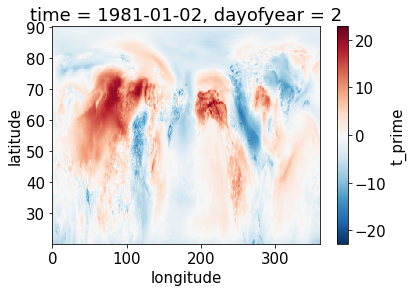

In [8]:
total_demean = xr.open_dataset('/project2/geos39650/jet_stream/data/demean_t_prime_1980_2020.nc4')
total_demean.isel(time=32).t_prime.plot()

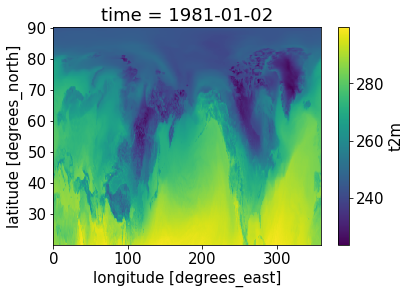

In [9]:
t2m = xr.open_dataset('/project2/geos39650/jet_stream/data/df_lat_20_1D.nc')
t2m.isel(time=32).t2m.plot()

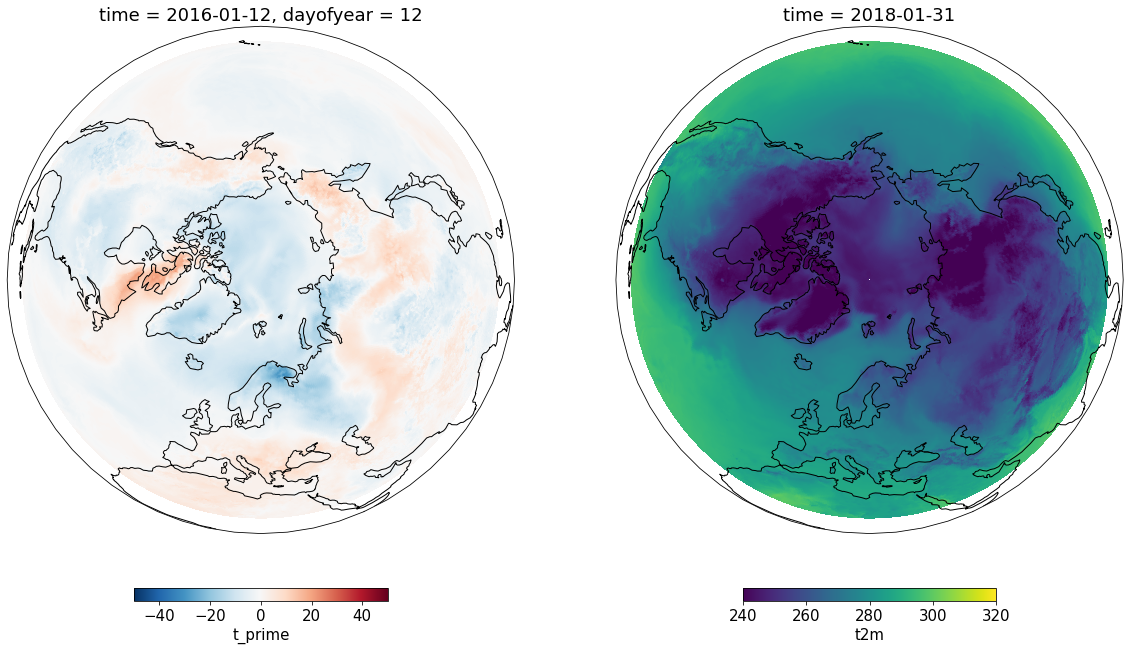

In [32]:
fig_ = plt.figure(figsize=(20, 20))
ax_1 = fig_.add_subplot(121, projection=ccrs.Orthographic(20, 90))
ax_2 = fig_.add_subplot(122, projection=ccrs.Orthographic(20, 90))

total_demean.isel(time=3200).t_prime.plot.pcolormesh(ax=ax_1,
                                      cmap='RdBu_r',
                                      vmax=-50,
                                      vmin=50,
                                      center=0,
                                      transform=ccrs.PlateCarree(),
                                      extend='neither',
                                      cbar_kwargs={'orientation': 'horizontal',
                                                  'pad': 0.05,
                                                  'shrink': 0.5,
                                                  'spacing': 'proportional'
                                                 }
                         )

t2m.isel(time=3400).t2m.plot.pcolormesh(ax=ax_2,
                                      #cmap='RdBu_r',
                                      vmin=240,
                                      vmax=320,
                                      #center=0,
                                      transform=ccrs.PlateCarree(),
                                      extend='neither',
                                      cbar_kwargs={'orientation': 'horizontal',
                                                  'pad': 0.05,
                                                  'shrink': 0.5,
                                                  'spacing': 'proportional'
                                                 }
                         )

ax_1.set_global()
ax_1.coastlines()
ax_2.set_global()
ax_2.coastlines()

### Loop over years to create a movie

In [ ]:
def plot_avg(data, ax, **kwargs):
    
    # Add layers to axis
    ax.set_global()
    ax.coastlines()
    
    # Plotting function
    data.plot.pcolormesh(ax = ax, 
                         transform=ccrs.PlateCarree(),
                         vmin =params['min'], 
                         vmax=params['max'] ,
                         cmap=params['colormap'], 
                         cbar_kwargs={'orientation': 'horizontal',
                                      'pad': 0.05,
                                      'shrink': 0.5,
                                      'spacing': 'proportional'
                                     }
                        )

In [130]:
for day in range(2800, 2950):    
    rat = (day - 2800)/(2950-2800) * (150 - 1) + 1
    print(int(np.ceil(rat)))
    
    fig = plt.subplots(figsize=(10, 10))

    total_demean.t_prime.isel(time=day).plot.pcolormesh(ax=ax,
                                          cmap='RdBu_r',
                                          vmax=40,
                                          vmin=-40,
                                          center=0.0,
                                          transform=ccrs.PlateCarree(),
                                          extend='neither',
                                          cbar_kwargs={'orientation': 'horizontal',
                                                      'pad': 0.05,
                                                      'shrink': 0.5,
                                                      'spacing': 'proportional'
                                                     }
                             )
    plt.tight_layout()
    ax.set_global()
    ax.coastlines()
    plt.savefig(f'{os.getenv("SCRATCH")}/figs/t_prime_decades_polar_div_{str(int(rat)).zfill(3)}.png')
    plt.clf()

1


/scratch/midway2/ivanhigueram/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


/scratch/midway2/ivanhigueram/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

### Loop over year with t2m side by side

In [38]:
top_range = 3400
ceil_range = 3200
for day in range(ceil_range, top_range): 
    rat = (day - ceil_range)/(top_range-ceil_range) * ((top_range-ceil_range) - 1) + 1
    print(int(np.ceil(rat)))


    fig_ = plt.figure(figsize=(20, 20))
    ax_1 = fig_.add_subplot(121, projection=ccrs.Orthographic(20, 90))
    ax_2 = fig_.add_subplot(122, projection=ccrs.Orthographic(20, 90))

    total_demean.isel(time=day).t_prime.plot.pcolormesh(ax=ax_1,
                                          cmap='RdBu_r',
                                          vmax=-50,
                                          vmin=50,
                                          center=0,
                                          transform=ccrs.PlateCarree(),
                                          extend='neither',
                                          cbar_kwargs={'orientation': 'horizontal',
                                                      'pad': 0.05,
                                                      'shrink': 0.5,
                                                      'spacing': 'proportional'
                                                     }
                             )

    t2m.isel(time=day).t2m.plot.pcolormesh(ax=ax_2,
                                          #cmap='RdBu_r',
                                          vmin=240,
                                          vmax=320,
                                          #center=0,
                                          transform=ccrs.PlateCarree(),
                                          extend='neither',
                                          cbar_kwargs={'orientation': 'horizontal',
                                                      'pad': 0.05,
                                                      'shrink': 0.5,
                                                      'spacing': 'proportional'
                                                     }
                             )

    ax_1.set_global()
    ax_1.coastlines()
    ax_2.set_global()
    ax_2.coastlines()

    plt.savefig(f'{os.getenv("SCRATCH")}/t2m_plots/t2m_t_prime_decades_polar_div_{str(int(rat)).zfill(3)}.png')
    plt.clf()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


/scratch/midway2/ivanhigueram/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

In [42]:
cube = iris.load_cube(fname,
                          iris.Constraint('surface_temperature',
                                          latitude=lambda v: -5 < v < 5))

# Take the mean over latitude
cube = cube.collapsed('latitude', iris.analysis.MEAN)

# Now that we have our data in a nice way, lets create the plot
# contour with 20 levels
qplt.contourf(cube, 20)

# Put a custom label on the y axis
plt.ylabel('Time / years')

# Stop matplotlib providing clever axes range padding
plt.axis('tight')

# As we are plotting annual variability, put years as the y ticks
plt.gca().yaxis.set_major_locator(mdates.YearLocator())

# And format the ticks to just show the year
plt.gca().yaxis.set_major_formatter(mdates.DateFormatter('%Y'))

iplt.show()
